# Toy Example

In [1]:
include("src/Misc.jl");
include("src/Datasets.jl");
include("src/BayesianCausality.jl")

Main.BayesianCausality

In [2]:
using .Misc, .BayesianCausality
import .Datasets

In [3]:
using Statistics
import Random: randperm, seed!

using PyPlot
seed!(1605);

In [4]:
MARKER = ["o", "v", "d", "X", "p", "*", "P"];
COLOR = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
RESULTS_PATH = "./results/toy";
PARAMS_PATH = "./params";
IMG = "./img"

N_PARAMS = 36

36

In [5]:
function accuracy(models,g_truth; weights=ones(length(models)))
    return sum((models .== g_truth) .* weights) / sum(weights)
end

accuracy (generic function with 1 method)

In [6]:
function spurious_pairs(models)
    return valid_pairs[(models .== 3)[:,1]]
end

spurious_pairs (generic function with 1 method)

## Read Parameters

In [7]:
N_PARAM = 20
params = Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$N_PARAM.json"))

γ, M = params[:γ], params[:M]
a₁, b₁, m₁, λ₁ = params[:a₁], params[:b₁], params[:m₁], params[:λ₁]
a₂, b₂, m₂, λ₂ = params[:a₂], params[:b₂], params[:m₂], params[:λ₂]

(1.0, 1.0, 0.0, 0.1)

In [8]:
causal_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₂, 
                     :M=>M, :a₁=>a₁, :a₂=>a₂, :b₁=>b₁, :b₂=>b₂);
spurious_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₁, 
                       :M=>1, :a₁=>a₁, :a₂=>a₁, :b₁=>b₁, :b₂=>b₁);

## Generate Data

In [9]:
T, R = 10, 3

(10, 3)

In [10]:
X₁, X₂ = generate(T, R; M=M, causal_params...)

[X₁ X₂]

10×2 Array{Float64,2}:
  0.941234     0.253076
  0.624588    -0.139422
  0.913828    -0.56707 
 -0.00237767   0.50479 
  0.084715    -7.30425 
 -0.592922    -4.9219  
  1.08197     -1.03617 
  0.33104      1.70343 
  0.0656882   -8.16663 
  0.816413    -0.647332

## Experiment

In [19]:
EPOCHS = 50
RPT = 100
Ps = 10 .^ (0:5)
R = 2

smc_mg_lkhd = Array{Float64}(undef,3,RPT,length(Ps));
vb_mg_lkhd = Array{Float64}(undef,3,RPT)
exact_mg_lkhd = Array{Float64}(undef,3);

In [20]:
for rel ∈ 1:3
    X = rel == 1 ? [X₁ X₂] : [X₂ X₁]
    M_rel = rel == 3 ? 1 : M
    hyper_params = rel == 3 ? spurious_params : causal_params
    exact_mg_lkhd[rel] = log_marginal(X, R; M=M_rel, hyper_params...)
    for rpt ∈ 1:RPT
        vb_mg_lkhd[rel,rpt] = v_bayes(X, R; EPOCHS=EPOCHS, M=M_rel, hyper_params...)[1][end]
        for (p,P) ∈ enumerate(Ps)
            smc_mg_lkhd[rel,rpt,p] = smc_weight(X, R, P; M=M_rel, hyper_params...)[1]
        end
    end
end

In [21]:
save_json("$RESULTS_PATH/exact_comparison.json", X=[X₁ X₂], 
          smc=smc_mg_lkhd, vb=vb_mg_lkhd, exact=exact_mg_lkhd);

## Read Results

In [79]:
function upper_interval((log_x, log_σ)) 
    base = max(log_x, log_σ)
    return base + log(exp(log_x-base) + exp(log_σ-base)) 
end

upper_interval (generic function with 2 methods)

In [122]:
function lower_interval((log_x, log_σ)) 
    base = max(log_x, log_σ)
    arg = exp(log_x-base) - exp(log_σ-base)
    return base + (arg < 0 ? -1000 : log(arg)) 
end

lower_interval (generic function with 2 methods)

In [141]:
results = load_json("$RESULTS_PATH/exact_comparison3.json")
exact_mg_lkhd = Float64.(results["exact"])
vb_mg_lkhd = nanmax(hcat(results["vb"]...),2)
smc_mg_lkhd = cat([hcat(part...) for part ∈ results["smc"]]...,dims=3);

In [142]:
log_σ = logvarexp(smc_mg_lkhd,2)/2
log_PX = logmeanexp(smc_mg_lkhd,2)

3×6 Array{Float64,2}:
 -33.6201  -33.6832  -33.6818  -33.6849  -33.6864  -33.6859
 -79.5748  -79.6011  -79.6232  -79.6068  -79.6117  -79.6109
 -68.1697  -68.2308  -68.2521  -68.2491  -68.2481  -68.2465

In [143]:
log_PX⁺ = map(upper_interval,zip(log_PX,log_σ))
log_PX⁻ = map(lower_interval,zip(log_PX,log_σ))

3×6 Array{Float64,2}:
   -34.194  -33.8778  -33.7326  -33.7012  -33.6915  -33.6877
 -1079.14   -80.2057  -79.7802  -79.6553  -79.6277  -79.6151
 -1068.15   -68.6101  -68.3751  -68.2891  -68.2594  -68.2504

In [144]:
exact_mg_lkhd

3-element Array{Float64,1}:
 -33.68615522735423
 -79.6118014668486 
 -68.24658364796666

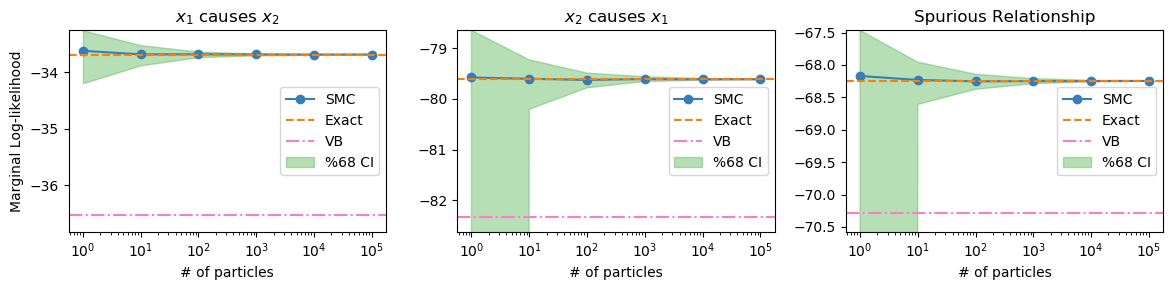

In [145]:
fig, ax = PyPlot.subplots(1, 3; figsize=(12,3))

for (rel,ttl) in enumerate(["\$x_1\$ causes \$x_2\$", "\$x_2\$ causes \$x_1\$", "Spurious Relationship"])
    ax[rel].semilogx(Ps, log_PX[rel,:]; label="SMC", marker=MARKER[1], color=COLOR[1])
    ax[rel].axhline(exact_mg_lkhd[rel]; label="Exact", color=COLOR[2], linestyle="--")
    ax[rel].fill_between(Ps, log_PX⁻[rel,:], log_PX⁺[rel,:]; label="%68 CI", color=COLOR[3], alpha=0.4)
    ax[rel].axhline(vb_mg_lkhd[rel]; label="VB", color=COLOR[4], linestyle="-.")
    ax[rel].set_ylim(vb_mg_lkhd[rel]-0.3,log_PX⁺[rel,1])
    
    ax[rel].set_xlabel("# of particles")
    ax[rel].set_title(ttl)
    ax[rel].legend()
end
ax[1].set_ylabel("Marginal Log-likelihood")
PyPlot.legend()
PyPlot.tight_layout()
PyPlot.savefig("$IMG/marginal_lkhd.pdf", bbox_inches="tight");

In [146]:
for rel ∈ 1:3
    X = rel == 1 ? [X₁ X₂] : [X₂ X₁]
    M_rel = rel == 3 ? 1 : M
    hyper_params = rel == 3 ? spurious_params : causal_params
    exact_mg_lkhd[rel] = log_marginal(X, 1; M=M_rel, hyper_params...)
end

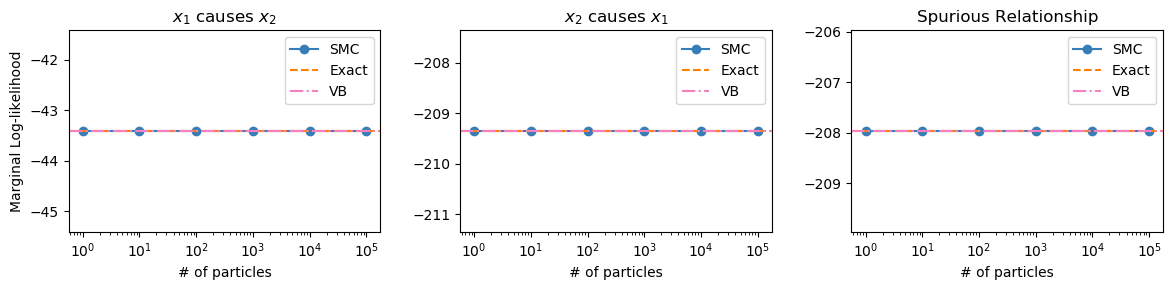

In [148]:
fig, ax = PyPlot.subplots(1, 3; figsize=(12,3))

for (rel,ttl) in enumerate(["\$x_1\$ causes \$x_2\$", "\$x_2\$ causes \$x_1\$", "Spurious Relationship"])
    ax[rel].semilogx(Ps, fill(exact_mg_lkhd[rel],6); label="SMC", marker=MARKER[1], color=COLOR[1])
    ax[rel].axhline(exact_mg_lkhd[rel]; label="Exact", color=COLOR[2], linestyle="--")
    #ax[rel].fill_between(Ps, log_PX⁻[rel,:], log_PX⁺[rel,:]; label="%68 CI", color=COLOR[3], alpha=0.4)
    ax[rel].axhline(exact_mg_lkhd[rel]; label="VB", color=COLOR[4], linestyle="-.")
    ax[rel].set_ylim(exact_mg_lkhd[rel]-2,exact_mg_lkhd[rel]+2)
    
    ax[rel].set_xlabel("# of particles")
    ax[rel].set_title(ttl)
    ax[rel].legend()
end
ax[1].set_ylabel("Marginal Log-likelihood")
PyPlot.legend()
PyPlot.tight_layout()
PyPlot.savefig("$IMG/marginal_lkhd.pdf", bbox_inches="tight");

In [10]:
tuebingen_data = Datasets.tuebingen(collect(1:100));

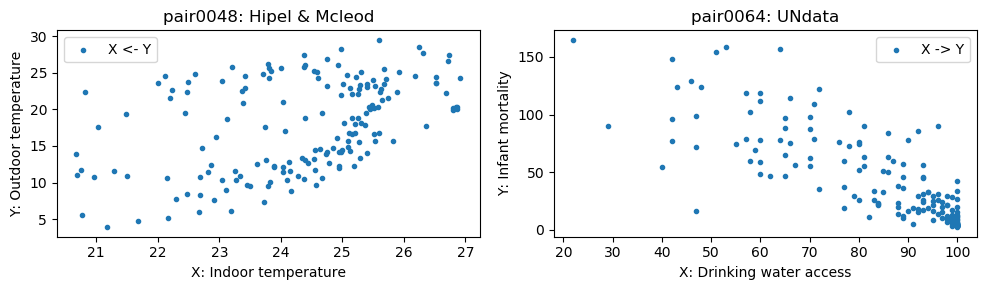

In [21]:
fig, ax = PyPlot.subplots(1, 2; figsize=(10,3))

for (n,pair) in enumerate(tuebingen_data[[48,64]])
    plot_pair(pair;ax=ax[n])
end
PyPlot.tight_layout()
PyPlot.savefig("./img/tuebingen.pdf", bbox_inches="tight");